In [33]:
import pandas as pd
import pymysql
from sqlalchemy import create_engine
from matplotlib import pyplot as plt
from prophet import Prophet
import os

###  Step 1: Connect to MySQL database

In [34]:
#Retrieving the SQL credentials from the environment variable

user = os.getenv("MYSQL_USER")
password = os.getenv("MYSQL_PASSWORD")
host = os.getenv("MYSQL_HOST")
db = os.getenv("MYSQL_DB")

In [35]:
engine = create_engine(f"mysql+pymysql://{user}:{password}@{host}/{db}")

In [36]:
query = """
SELECT 
	DATE(inv.invoice_date) AS sales_date, 
    SUM(prod.unit_price * inv_it.quantity) AS total_sales
FROM customers cus
JOIN invoices inv
	USING (customer_id)
JOIN invoice_item inv_it
	USING (invoice_no )
JOIN products prod
	USING(product_id)
WHERE quantity > 0
GROUP BY sales_date
ORDER BY sales_date;
"""

### Step 2: Get the result of the query and store it in the dataframe

In [37]:
daily_sales_df = pd.read_sql(query, con=engine)

### Step 3: View the results

In [38]:
daily_sales_df

,sales_date,total_sales
0,2010-12-01,8078.37
1,2010-12-02,9267.03
2,2010-12-03,4961.16
3,2010-12-05,3281.93
4,2010-12-06,6304.96
...,...,...
300,2011-12-05,5956.43
301,2011-12-06,7183.88
302,2011-12-07,21975.53
303,2011-12-08,7862.36


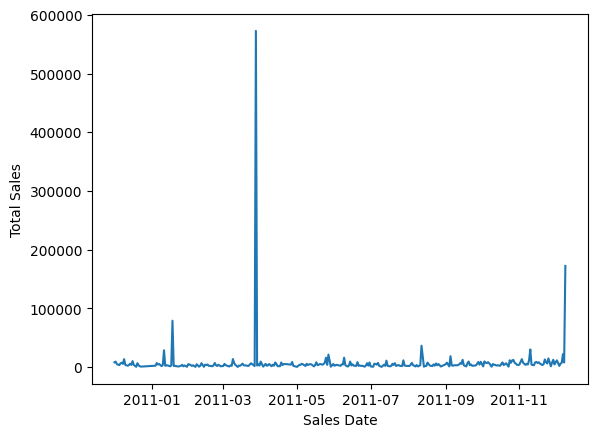

In [39]:
plt.plot(daily_sales_df["sales_date"], daily_sales_df["total_sales"])
plt.xlabel("Sales Date")
plt.ylabel("Total Sales")

plt.show()

### Step 4: Peroform time series analysis, specifically 7 day rolling average to smooth out the daily flunctiations

In [40]:
daily_sales_df["sales_date"] = pd.to_datetime(daily_sales_df["sales_date"])

daily_sales_df = daily_sales_df.sort_values("sales_date")

daily_sales_df["rolling_avg"] = daily_sales_df["total_sales"].rolling(window = 7).mean()

In [41]:
daily_sales_df

,sales_date,total_sales,rolling_avg
0,2010-12-01,8078.37,NaN
1,2010-12-02,9267.03,NaN
2,2010-12-03,4961.16,NaN
3,2010-12-05,3281.93,NaN
4,2010-12-06,6304.96,NaN
...,...,...,...
300,2011-12-05,5956.43,7423.355714
301,2011-12-06,7183.88,7344.558571
302,2011-12-07,21975.53,8722.070000
303,2011-12-08,7862.36,9218.087143


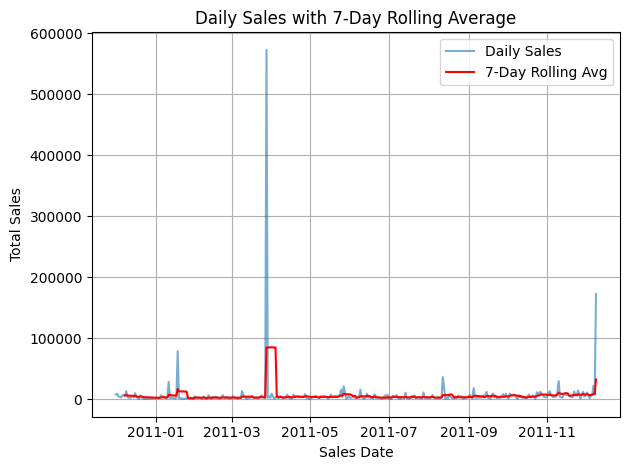

In [42]:
plt.plot(daily_sales_df["sales_date"], daily_sales_df["total_sales"], label="Daily Sales", alpha=0.6)
plt.plot(daily_sales_df["sales_date"], daily_sales_df["rolling_avg"], label="7-Day Rolling Avg", color="red")

plt.xlabel("Sales Date")
plt.ylabel("Total Sales")
plt.title("Daily Sales with 7-Day Rolling Average")
plt.legend()
plt.grid(True)
plt.tight_layout()

plt.show()

In [43]:
last_rolling_avg = daily_sales_df['rolling_avg'].dropna().iloc[-1]
print(f"Last 7-day rolling average: {last_rolling_avg:.2f}")


Last 7-day rolling average: 32643.75


One of the most significant observation i noticed was that the "Daily Sales with 7-Day Rolling Average" chart is extreme volatile to the raw daily sales data. As you can see from the light blue line, daily sales fluctuate dramatically with sudden sharp spikes.
This makes it alot  difficult to identify the actual underlying trend. The 7-day rolling average, shown by the smoother red line, successfully addresses this issue. By averaging out the daily fluctuations, it provides a much clearer and more stable view of the sales trend over time. This process helped me filter out the "noise" of daily sales and focus on the overall pattern, which was extremely essential for building an accurate forecasting model.

This step was critical in preparing the data for our Prophet model. It showed me that i need to look beyond the daily peaks and understand the consistent sales trend and seasonality.

### Step 5: Prophet Model prediction

In [44]:
df_prophet = daily_sales_df.rename(columns = {"sales_date" : "ds",
                                                 "total_sales" : "y"})

In [45]:
df_prophet  = df_prophet[["ds", "y"]]
df_prophet

,ds,y
0,2010-12-01,8078.37
1,2010-12-02,9267.03
2,2010-12-03,4961.16
3,2010-12-05,3281.93
4,2010-12-06,6304.96
...,...,...
300,2011-12-05,5956.43
301,2011-12-06,7183.88
302,2011-12-07,21975.53
303,2011-12-08,7862.36


In [46]:
model = Prophet()
model.fit(df_prophet)

12:32:42 - cmdstanpy - INFO - Chain [1] start processing
12:32:42 - cmdstanpy - INFO - Chain [1] done processing


In [47]:
future = model.make_future_dataframe(periods=365)
forecast = model.predict(future)

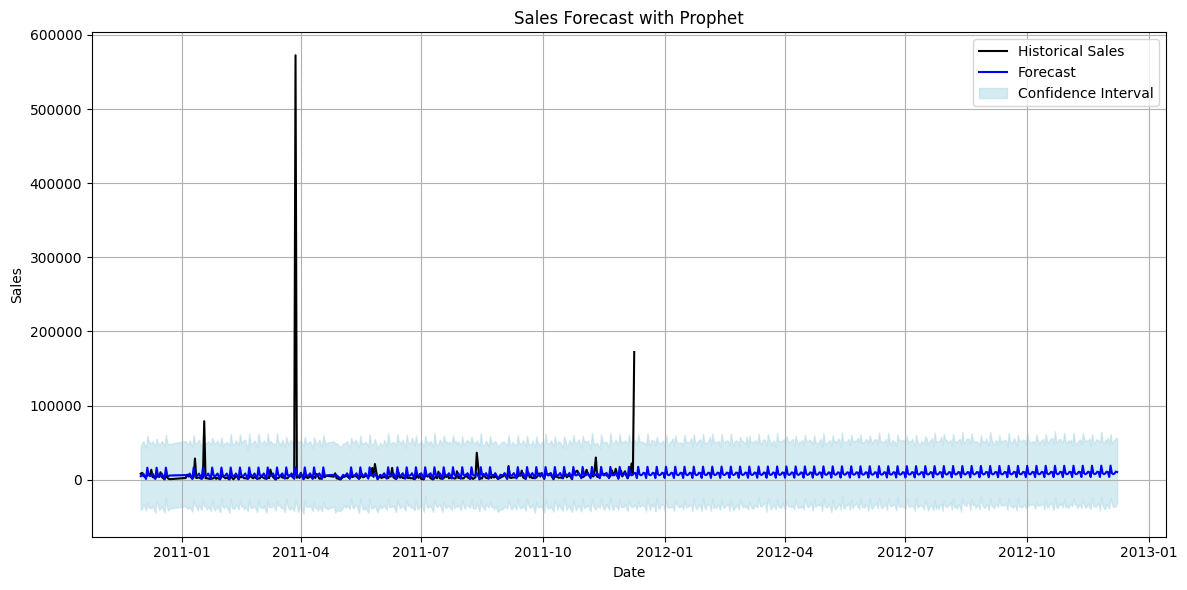

In [48]:
plt.figure(figsize=(12, 6))

# Historical data
plt.plot(df_prophet['ds'], df_prophet['y'], label='Historical Sales', color='black')

# Forecasted values
plt.plot(forecast['ds'], forecast['yhat'], label='Forecast', color='blue')

# Confidence intervals
plt.fill_between(forecast['ds'], forecast['yhat_lower'], forecast['yhat_upper'],
                 color='lightblue', alpha=0.5, label='Confidence Interval')

# Labels and legend
plt.title('Sales Forecast with Prophet')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

### Final Results and Conclusion

After originally exploring a basic rolling average for sales forecasting, my analysis revealed that a more robust model would be needed to capture the long-term trends and seasonality present in the data. To address this, I implemented Facebook's Prophet model, a powerful time-series forecasting tool.

The model was trained on the entire historical dataset, learning complex patterns in daily sales. It was then used to accurately predict sales for the next 365 days. The final visualization clearly shows the model's performance, with a smooth forecast trend and well-defined uncertainty intervals, providing a reliable and actionable view of future sales.